# Assignment
- 아래 코드를 완성하여 다중레이블 분류문제를 푸는 신경망을 학습하고자 한다.

In [ ]:
# 아래의 패키지 중 numpy, matplotlib는 기존에 설치되어 있어야 한다.
# spiral.py가 본 주피터 노트북 파일과 같은 디렉토리에 있어야 한다.
import numpy as np
import sys
import spiral
import matplotlib.pyplot as plt

In [ ]:
# 이 블럭의 코드는 수정하지 않고 그대로 실행하여 사용한다.
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    # 정답 데이터가 원핫 벡터일 경우 정답 레이블 인덱스로 변환
    if t.size == y.size:
        t = t.argmax(axis=1)

    batch_size = y.shape[0]

    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax(x):
    if x.ndim == 2:
        x = x - x.max(axis=1, keepdims=True)
        x = np.exp(x)
        x /= x.sum(axis=1, keepdims=True)
    elif x.ndim == 1:
        x = x - np.max(x)
        x = np.exp(x) / np.sum(np.exp(x))

    return x


class SoftmaxWithLoss:
    def __init__(self):
        self.params, self.grads = [], []
        self.y = None  # softmax의 출력
        self.t = None  # 정답 레이블

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)

        # 정답 레이블이 원핫 벡터일 경우 정답의 인덱스로 변환
        if self.t.size == self.y.size:
            self.t = self.t.argmax(axis=1)

        loss = cross_entropy_error(self.y, self.t)
        return loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]

        dx = self.y.copy()
        dx[np.arange(batch_size), self.t] -= 1
        dx *= dout
        dx = dx / batch_size

        return dx

Problem 1.
다음 레이어들에 대한 클래스를 정의하는 파이썬 코드를 완성하라.
- Affine
- Sigmoid

In [ ]:
class Affine:
    """활성값 객체 구현"""

    def __init__(self, W, b):
        """
        가중치, 바이어스를 매개변수(parameter)로 저장한다.
        가중치, 바이어스는 학습 과정에서 갱신된다.
        """
        self.params = [W, b]
        self.grads = [np.zeros_like(W), np.zeros_like(b)]
        self.x = None

    def forward(self, x):
        """순전파"""
        W, b = self.params
        self.x = x
        return self.x @ W + b


    def backward(self, dout):
        """역전파"""
        # Write your code here.
        W,b = self.params
        dW = self.x.T @ dout
        db = np.sum(dout, axis=0)

        self.grads[0][:] = dW
        self.grads[1][:] = db
        return dout @ W.T

In [ ]:
class Sigmoid:
    """시그모이드 객체 구현"""

    def __init__(self):
        self.params, self.grads = [], []
        self.out = None

    def forward(self, x):
        """순전파"""
        self.out = 1 / (1 + np.exp(-x))
        return self.out

    def backward(self, dout):
        """역전파"""
        return dout * (1. - self.out) * self.out

## Problem 2.
Stochastic gradient descent 알고리즘을 클래스로 구현하라.

In [29]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for i, param in enumerate(params):
            param -= self.lr * grads[i]


## Problem 3.
아래 그림과 같은 구조를 갖는 신경망 `TwoLayerNet`을 클래스로 구현하는 코드를 완성하라.

(`Affine`-`Sigmoid`-`Affine`-`SoftmaxWithLoss`)

![](https://fmcl.synology.me/image/deep_learning_2_images/fig%201-13)


In [32]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size):
        I, H, O = input_size, hidden_size, output_size

        # 가중치와 편향 초기화
        np.random.seed(2023)
        W1 = np.random.randn(I, H)
        b1 = np.random.randn(H)
        W2 = np.random.randn(H, O)
        b2 = np.random.randn(O)

        # 계층 생성
        self.layers = [Affine(W1, b1), Sigmoid(), Affine(W2, b2)]
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치를 리스트에 모은다.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def predict(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def forward(self, x, t):
        score = self.predict(x)
        loss = self.loss_layer.forward(score, t)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

## Problem 4.
다음 블럭의 코드는 주어진 spiral 데이터셋을 사용하여 3개의 레이블에 대한 다중레이블 분류를 수행하는 신경망을 훈련시키는 코드다.
- 앞에서 문제 1~3에서 개발한 클래스들이 아래 코드를 실행하여 문제없이 잘 동작하는지 확인하라.

### Problem 4.1.
- `batch_size`를 1, 5, 30으로 변경시켜서 각각 훈련하였을 때, 시각화 결과와 손실함수 변화 그래프를 비교하고 설명하라.

### Problem 4.2.
- `learning_rate`를 0.1, 1, 20으로 변경시켜서 각각 훈련하였을 때, 시각화 결과와 손실함수 변화 그래프를 비교하고 설명하라.

### Problem 4.3.
- `hidden_size`를 10, 100으로 변경시켜서 각각 훈련하였을 때, 시각화에 걸리는 시간과 손실함수 변화 그래프를 비교하고 설명하라.

| 에폭 1 | 반복 10 / 10 | 손실 1.32
| 에폭 2 | 반복 10 / 10 | 손실 0.88
| 에폭 3 | 반복 10 / 10 | 손실 0.81
| 에폭 4 | 반복 10 / 10 | 손실 0.81
| 에폭 5 | 반복 10 / 10 | 손실 0.79
| 에폭 6 | 반복 10 / 10 | 손실 0.75
| 에폭 7 | 반복 10 / 10 | 손실 0.80
| 에폭 8 | 반복 10 / 10 | 손실 0.79
| 에폭 9 | 반복 10 / 10 | 손실 0.77
| 에폭 10 | 반복 10 / 10 | 손실 0.76
| 에폭 11 | 반복 10 / 10 | 손실 0.73
| 에폭 12 | 반복 10 / 10 | 손실 0.77
| 에폭 13 | 반복 10 / 10 | 손실 0.74
| 에폭 14 | 반복 10 / 10 | 손실 0.73
| 에폭 15 | 반복 10 / 10 | 손실 0.72
| 에폭 16 | 반복 10 / 10 | 손실 0.74
| 에폭 17 | 반복 10 / 10 | 손실 0.71
| 에폭 18 | 반복 10 / 10 | 손실 0.73
| 에폭 19 | 반복 10 / 10 | 손실 0.72
| 에폭 20 | 반복 10 / 10 | 손실 0.73
| 에폭 21 | 반복 10 / 10 | 손실 0.71
| 에폭 22 | 반복 10 / 10 | 손실 0.69
| 에폭 23 | 반복 10 / 10 | 손실 0.71
| 에폭 24 | 반복 10 / 10 | 손실 0.69
| 에폭 25 | 반복 10 / 10 | 손실 0.69
| 에폭 26 | 반복 10 / 10 | 손실 0.70
| 에폭 27 | 반복 10 / 10 | 손실 0.68
| 에폭 28 | 반복 10 / 10 | 손실 0.69
| 에폭 29 | 반복 10 / 10 | 손실 0.67
| 에폭 30 | 반복 10 / 10 | 손실 0.69
| 에폭 31 | 반복 10 / 10 | 손실 0.67
| 에폭 32 | 반복 10 / 10 | 손실 0.67
| 에폭 33 | 반복 10 /

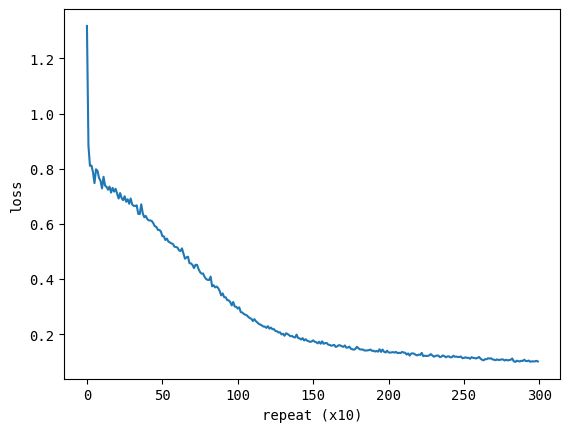

In [33]:
# 하이퍼파라미터 설정
max_epoch = 300
batch_size = 30
hidden_size = 10
learning_rate = 1

# 데이터 읽기, 모델 및 옵티마이저 생성
x, t = spiral.load_data()
model = TwoLayerNet(input_size=2, hidden_size=hidden_size, output_size=3)
optimizer = SGD(lr=learning_rate)

# 학습에 사용하는 변수
data_size = len(x)
max_iters = data_size // batch_size
total_loss = 0
loss_count = 0
loss_list = []

for epoch in range(max_epoch):
    # 데이터 섞기
    idx = np.random.permutation(data_size)
    x = x[idx]
    t = t[idx]

    for iters in range(max_iters):
        batch_x = x[iters * batch_size : (iters + 1) * batch_size]
        batch_t = t[iters * batch_size : (iters + 1) * batch_size]

        # 기울기 계산 -> 매개변수 계산
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)

        total_loss += loss
        loss_count += 1

        # 정기적으로 훈련결과 출력
        if (iters + 1) % 10 == 0:
            avg_loss = total_loss / loss_count
            print(
                "| 에폭 %d | 반복 %d / %d | 손실 %.2f"
                % (epoch + 1, iters + 1, max_iters, avg_loss)
            )
            loss_list.append(avg_loss)
            total_loss, loss_count = 0, 0
# 학습 결과 플롯

plt.rc("font", family="monospace")
plt.plot(np.arange(len(loss_list)), loss_list, label="train")
plt.xlabel("repeat (x10)")
plt.ylabel("loss")
plt.show()

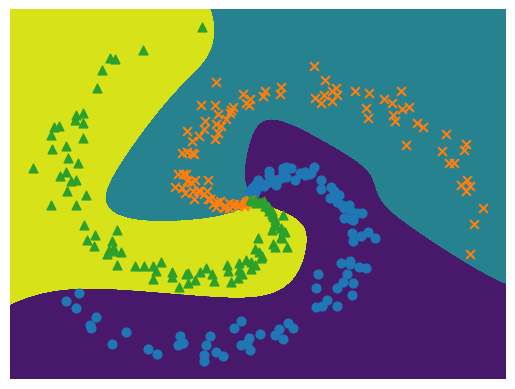

In [ ]:
# 결과 시각화 스크립트

# 경계 영역 플롯
h = 0.001
x_min, x_max = x[:, 0].min() - 0.1, x[:, 0].max() + 0.1
y_min, y_max = x[:, 1].min() - 0.1, x[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
X = np.c_[xx.ravel(), yy.ravel()]
score = model.predict(X)
predict_cls = np.argmax(score, axis=1)
Z = predict_cls.reshape(xx.shape)
plt.contourf(xx, yy, Z)
plt.axis("off")

# 데이터점 플롯
x, t = spiral.load_data()
N = 100
CLS_NUM = 3
markers = ["o", "x", "^"]
for i in range(CLS_NUM):
    plt.scatter(
        x[i * N : (i + 1) * N, 0], x[i * N : (i + 1) * N, 1], s=40, marker=markers[i]
    )
plt.show()